In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import os, random, re, math, time
random.seed(a=42)
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
import PIL
from kaggle_datasets import KaggleDatasets
from tqdm import tqdm

## using the TPU


In [6]:
DEVICE = "TPU"
CFG = dict(
    net_count         =   2,
    batch_size        =  16,
    
    read_size         = 256, 
    crop_size         = 256, 
    net_size          = 256, 
    
    LR_START          =   0.000005,
    LR_MAX            =   0.000020,
    LR_MIN            =   0.000001,
    LR_RAMPUP_EPOCHS  =   5,
    LR_SUSTAIN_EPOCHS =   0,
    LR_EXP_DECAY      =   0.8,
    epochs            =  25,
    
    rot               = 180.0,
    shr               =   2.0,
    hzoom             =   8.0,
    wzoom             =   8.0,
    hshift            =   8.0,
    wshift            =   8.0,

    optimizer         = 'adam',
    label_smooth_fac  =   0.05,
    
    tta_steps         =  25    
)

In [7]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.0.0.2:8470
initializing  TPU ...
TPU initialized
REPLICAS: 8


## Reading in the data

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


### check for missing values

In [4]:
df.isna().any()
df = df.dropna()

### check unique values in each column

In [5]:
print("Count of male and female ", df.sex.value_counts())
print("uniques in anatom_site_general_challenge column ", df.anatom_site_general_challenge.unique())
print("uniques in diagnosis column ", df.diagnosis.unique())
print("uniques in benign_malignant column ", df.benign_malignant.unique())

Count of male and female  male      16788
female    15743
Name: sex, dtype: int64
uniques in anatom_site_general_challenge column  ['head/neck' 'upper extremity' 'lower extremity' 'torso' 'palms/soles'
 'oral/genital']
uniques in diagnosis column  ['unknown' 'nevus' 'melanoma' 'seborrheic keratosis' 'lentigo NOS'
 'lichenoid keratosis' 'solar lentigo' 'cafe-au-lait macule'
 'atypical melanocytic proliferation']
uniques in benign_malignant column  ['benign' 'malignant']


### visualizations


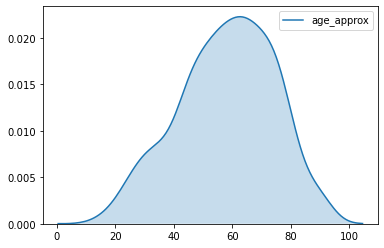

In [6]:
sns.kdeplot(df[(df['target'] == 1)].age_approx, shade = True)

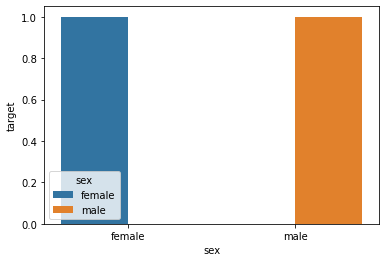

In [7]:
dummy = df[df['target'] == 1]

sns.barplot(x = "sex", y = "target", data = dummy, hue ="sex")



### conduct data analysis

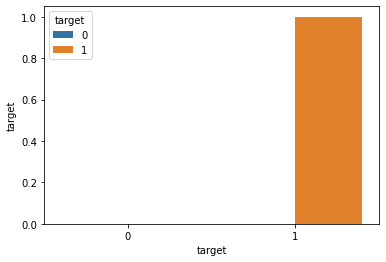

In [9]:
# viewing the distributions of data 

sns.barplot(x = "target", y = "target", data = df, hue ="target")

## hence the number of unaffected surpasses the affected, we need to normalise this data. But we need to understand 
# various other columns before normalising this data

### lets see the distributions of sex  in  unaffected before removing normalizing

In [23]:
print("no of unaffected males  : ", len(df[(df['target'] == 0) & (df['sex'] == 'male')]))
print("no of unaffected females  : ", len(df[(df['target'] == 0) & (df['sex'] == 'female')]))

## not. much of a difference in. the ratios

no of unaffected males  :  16430
no of unaffected females  :  15526


In [24]:
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


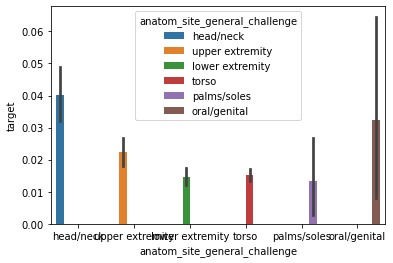

In [25]:
sns.barplot(x = "anatom_site_general_challenge", y = "target", data = df, hue ="anatom_site_general_challenge")


In [28]:
df.anatom_site_general_challenge.unique()

array(['head/neck', 'upper extremity', 'lower extremity', 'torso',
       'palms/soles', 'oral/genital'], dtype=object)

In [29]:
print("no of head/neck  : ", len(df[(df['target'] == 0) & (df['anatom_site_general_challenge'] == 'head/neck')]))
print("no of upper extremity  : ", len(df[(df['target'] == 0) & (df['anatom_site_general_challenge'] == 'upper extremity')]))
print("no of lower extremity  : ", len(df[(df['target'] == 0) & (df['anatom_site_general_challenge'] == 'lower extremity')]))
print("no of torso  : ", len(df[(df['target'] == 0) & (df['anatom_site_general_challenge'] == 'torso')]))
print("no of palms/soles'  : ", len(df[(df['target'] == 0) & (df['anatom_site_general_challenge'] == 'palms/soles')]))
print("no of oral/genital'  : ", len(df[(df['target'] == 0) & (df['anatom_site_general_challenge'] == 'oral/genital')]))

no of head/neck  :  1771
no of upper extremity  :  4852
no of lower extremity  :  8275
no of torso  :  16568
no of palms/soles'  :  370
no of oral/genital'  :  120


In [18]:
tempdf = pd.get_dummies(tempdf, prefix = ['sex'],  columns = ['sex'])
tempdf = pd.get_dummies(tempdf, prefix = ['anatom'], columns = ['anatom_site_general_challenge'])
tempdf = pd.get_dummies(tempdf, prefix = ['diagnosis'], columns = ['diagnosis'])
tempdf = pd.get_dummies(tempdf, prefix = ['benign_malignant'], columns = ['benign_malignant'])

In [19]:
tempdf = tempdf.drop(columns = ['sex_male', 'anatom_oral/genital', 'diagnosis_melanoma', 'benign_malignant_benign'])

## reading input images

In [ ]:
import cv2 
img = cv2.imread('../input/siim-isic-melanoma-classification/jpeg/train/ISIC_0015719.jpg')
img.shape

In [24]:
tempdf.head()

,image_name,patient_id,age_approx,target,sex_female,anatom_head/neck,anatom_lower extremity,anatom_palms/soles,anatom_torso,anatom_upper extremity,diagnosis_atypical melanocytic proliferation,diagnosis_cafe-au-lait macule,diagnosis_lentigo NOS,diagnosis_lichenoid keratosis,diagnosis_nevus,diagnosis_seborrheic keratosis,diagnosis_solar lentigo,diagnosis_unknown,benign_malignant_malignant
0,ISIC_2637011,IP_7279968,45.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,ISIC_0015719,IP_3075186,45.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,ISIC_0052212,IP_2842074,50.0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0
3,ISIC_0068279,IP_6890425,45.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,ISIC_0074268,IP_8723313,55.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [34]:
realdf = tempdf[tempdf['target'] == 1]
dummy = tempdf[tempdf['target']  == 1]

TypeError: drop() got an unexpected keyword argument 'rows'

In [37]:
dummy = tempdf[tempdf['target']  == 0]

,image_name,patient_id,age_approx,target,sex_female,anatom_head/neck,anatom_lower extremity,anatom_palms/soles,anatom_torso,anatom_upper extremity,diagnosis_atypical melanocytic proliferation,diagnosis_cafe-au-lait macule,diagnosis_lentigo NOS,diagnosis_lichenoid keratosis,diagnosis_nevus,diagnosis_seborrheic keratosis,diagnosis_solar lentigo,diagnosis_unknown,benign_malignant_malignant
0,ISIC_2637011,IP_7279968,45.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,ISIC_0015719,IP_3075186,45.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,ISIC_0052212,IP_2842074,50.0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0
3,ISIC_0068279,IP_6890425,45.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,ISIC_0074268,IP_8723313,55.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33121,ISIC_9999134,IP_6526534,50.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
33122,ISIC_9999320,IP_3650745,65.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
33123,ISIC_9999515,IP_2026598,20.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
33124,ISIC_9999666,IP_7702038,50.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [21]:
import cv2
import pathlib
import imageio
from skimage.transform import resize
import numpy as np

#converting normal images into numpy array


training_paths = pathlib.Path('../input/siim-isic-melanoma-classification/jpeg').glob('train/*.jpg')
training_sorted = sorted([x for x in training_paths])

training_images = np.zeros(157323)
for index in range(len(tempdf)):
    im_path = training_sorted[index]
    img = cv2.imread(str(im_path))
    res = cv2.resize(img, dsize=(229, 229), interpolation=cv2.INTER_CUBIC)
    res = res.flatten()
    training_images = np.vstack((training_images, res))
    print(index)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 